In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crime-cast-forecasting-crime-categories/sample.csv
/kaggle/input/crime-cast-forecasting-crime-categories/train.csv
/kaggle/input/crime-cast-forecasting-crime-categories/test.csv


# **Table Of Contents**
* ### [Importing Libraries](#t1)
* ### [Loading the Data](#t2)
* ### [EDA(Exploratory Data Analysis)](#t3)
* ### [Descriptive Statistics](#t11)
* ### [Missing Values](#t10)
* ### [Target Variable Distribution](#t5)
* ### [Univariate Analysis](#t6)
* ### [Multivariate Analysis](#t7)
* ### [Dropping Redundant Columns Before Preprocessing](#t12)
* ### [Preprocessing](#t8)
* ### [Model Selection and Evaluation](#t9)
    * #### [Random Forest Classifier](#t15)
    * #### [LGBM Classifier](#t16)
    * #### [XGBoost Classifier](#t17)
    * #### [Model Evaluation](#t18)
* ### [Hyperparameter Tuning](#t13)

<a id="t1"></a>
# **Importing Libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
!pip install geodatasets
import geodatasets
from wordcloud import WordCloud, STOPWORDS
from imblearn.over_sampling import SMOTE

%matplotlib inline

<a id="t2"></a>
# **Loading the Data**

In [3]:
train_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv')
test_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv')

In [4]:
# Snapshot of training data
train_data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description,Crime_Category
0,4500 CARPENTER AV,NaN,34.1522,-118.3910,03/09/2020 12:00:00 AM,03/06/2020 12:00:00 AM,1800.0,15.0,N Hollywood,1563.0,...,75.0,M,W,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
1,45TH ST,ALAMEDA ST,34.0028,-118.2391,02/27/2020 12:00:00 AM,02/27/2020 12:00:00 AM,1345.0,13.0,Newton,1367.0,...,41.0,M,H,216.0,SWAP MEET,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes
2,600 E MARTIN LUTHER KING JR BL,NaN,34.0111,-118.2653,08/21/2020 12:00:00 AM,08/21/2020 12:00:00 AM,605.0,13.0,Newton,1343.0,...,67.0,M,B,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,Property Crimes
3,14900 ORO GRANDE ST,NaN,34.2953,-118.4590,11/08/2020 12:00:00 AM,11/06/2020 12:00:00 AM,1800.0,19.0,Mission,1924.0,...,61.0,M,H,101.0,STREET,NaN,NaN,IC,Invest Cont,Property Crimes
4,7100 S VERMONT AV,NaN,33.9787,-118.2918,02/25/2020 12:00:00 AM,02/25/2020 12:00:00 AM,1130.0,12.0,77th Street,1245.0,...,0.0,X,X,401.0,MINI-MART,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,Property Crimes


In [5]:
# Snapshot of test data
test_data.head()

,Location,Cross_Street,Latitude,Longitude,Date_Reported,Date_Occurred,Time_Occurred,Area_ID,Area_Name,Reporting_District_no,...,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Premise_Description,Weapon_Used_Code,Weapon_Description,Status,Status_Description
0,1500 LEIGHTON AV,NaN,34.0128,-118.3045,03/03/2020 12:00:00 AM,03/03/2020 12:00:00 AM,2000.0,3.0,Southwest,376.0,...,0416 1241 1243 1813 1821 2000,28.0,F,H,501.0,SINGLE FAMILY DWELLING,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont
1,100 S NORMANDIE AV,NaN,34.0726,-118.3029,06/01/2020 12:00:00 AM,04/25/2020 12:00:00 AM,1700.0,20.0,Olympic,2014.0,...,0344 0394,26.0,M,B,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,NaN,IC,Invest Cont
2,300 E 111TH ST,NaN,33.9348,-118.2695,08/28/2020 12:00:00 AM,08/27/2020 12:00:00 AM,900.0,18.0,Southeast,1844.0,...,1822 0701 1914 0355 1202 0100,62.0,F,B,721.0,HIGH SCHOOL,NaN,NaN,IC,Invest Cont
3,1300 S LA BREA AV,NaN,34.0497,-118.3442,12/23/2020 12:00:00 AM,12/03/2020 12:00:00 AM,2200.0,7.0,Wilshire,765.0,...,NaN,0.0,NaN,NaN,108.0,PARKING LOT,NaN,NaN,IC,Invest Cont
4,11000 MORRISON ST,NaN,34.1611,-118.3704,08/30/2020 12:00:00 AM,08/29/2020 12:00:00 AM,130.0,15.0,N Hollywood,1555.0,...,1501,37.0,F,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,AO,Adult Other


<a id="t3"></a>
# **EDA(Exploratory Data Analysis)**

* ### *Shape of the Dataset*

In [6]:
train_data.shape

(20000, 22)

In [7]:
test_data.shape

(5000, 21)

* ### *List of Columns in the Dataset*

In [8]:
train_data.columns

Index(['Location', 'Cross_Street', 'Latitude', 'Longitude', 'Date_Reported',
       'Date_Occurred', 'Time_Occurred', 'Area_ID', 'Area_Name',
       'Reporting_District_no', 'Part 1-2', 'Modus_Operandi', 'Victim_Age',
       'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Premise_Description',
       'Weapon_Used_Code', 'Weapon_Description', 'Status',
       'Status_Description', 'Crime_Category'],
      dtype='object')

* ### *Finding the data types and null values in the Dataset*

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               20000 non-null  object 
 1   Cross_Street           3448 non-null   object 
 2   Latitude               20000 non-null  float64
 3   Longitude              20000 non-null  float64
 4   Date_Reported          20000 non-null  object 
 5   Date_Occurred          20000 non-null  object 
 6   Time_Occurred          20000 non-null  float64
 7   Area_ID                20000 non-null  float64
 8   Area_Name              20000 non-null  object 
 9   Reporting_District_no  20000 non-null  float64
 10  Part 1-2               20000 non-null  float64
 11  Modus_Operandi         17259 non-null  object 
 12  Victim_Age             20000 non-null  float64
 13  Victim_Sex             17376 non-null  object 
 14  Victim_Descent         17376 non-null  object 
 15  Pr

In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Location               5000 non-null   object 
 1   Cross_Street           810 non-null    object 
 2   Latitude               5000 non-null   float64
 3   Longitude              5000 non-null   float64
 4   Date_Reported          5000 non-null   object 
 5   Date_Occurred          5000 non-null   object 
 6   Time_Occurred          5000 non-null   float64
 7   Area_ID                5000 non-null   float64
 8   Area_Name              5000 non-null   object 
 9   Reporting_District_no  5000 non-null   float64
 10  Part 1-2               5000 non-null   float64
 11  Modus_Operandi         4316 non-null   object 
 12  Victim_Age             5000 non-null   float64
 13  Victim_Sex             4357 non-null   object 
 14  Victim_Descent         4357 non-null   object 
 15  Prem

### **Insights**


#### 1. `Location`, `Cross_Street`, `Date_Reported`, `Date_Occurred`, `Area_Name`, `Modus_Operandi`, `Victim_Sex`, `Victim_Descent`, `Premise_Description`, `Weapon_Description`, `Status`, `Status_Description` are all of dtype **object**.
#### 2. `Latitude`, `Longitude`, `Time_Occurred`, `Area_ID`, `Reporting_District_no`, `Part 1-2`, `Victim_Age`, `Premise_Code`, `Weapon_Used_Code` are all of dtype **float64**.
#### 3. `Cross_Street`, `Modus_Operandi`, `Victim_Sex`, `Victim_Descent`, `Weapon_Used_Code`, `Weapon_Description`,`Premise_Description` possess null values which needs to be taken care of during the preprocessing if we are going to use them during model training.

<a id="t11"></a>
* ### *Descriptive Statistics*

In [11]:
train_data.describe()

,Latitude,Longitude,Time_Occurred,Area_ID,Reporting_District_no,Part 1-2,Victim_Age,Premise_Code,Weapon_Used_Code
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,7335.000000
mean,33.940704,-117.893072,1352.380350,10.834250,1129.599200,1.418150,30.135000,297.176950,366.405044
std,2.126810,7.377726,646.100291,6.033166,603.330519,0.493267,21.863645,212.007298,120.485687
min,0.000000,-118.663400,1.000000,1.000000,101.000000,1.000000,-2.000000,101.000000,101.000000
25%,34.009200,-118.429700,930.000000,6.000000,632.000000,1.000000,12.000000,101.000000,312.000000
50%,34.058700,-118.323000,1430.000000,11.000000,1162.000000,1.000000,31.000000,203.000000,400.000000
75%,34.165025,-118.274400,1900.000000,16.000000,1622.000000,2.000000,46.000000,501.000000,400.000000
max,34.328100,0.000000,2359.000000,21.000000,2197.000000,2.000000,99.000000,969.000000,515.000000


### **Insights**

#### 1. Average age of the victim is around `30 years`.
#### 2. At least half of the cases in the dataset fall under the "1" category mentioned under the `Part 1-2` column.
#### 3. At least half of the cases in the dataset have a `Premise_Code` in between 101 and 203.
#### 4. `Minimum value` of `Victim Age` along with any other negative ages would require corrections.

<a id="t10"></a>
* ### *Missing Values*

In [12]:
# Percentage of null values feature-wise in train_data
train_data.isna().sum()/len(train_data)*100

Location                  0.000
Cross_Street             82.760
Latitude                  0.000
Longitude                 0.000
Date_Reported             0.000
Date_Occurred             0.000
Time_Occurred             0.000
Area_ID                   0.000
Area_Name                 0.000
Reporting_District_no     0.000
Part 1-2                  0.000
Modus_Operandi           13.705
Victim_Age                0.000
Victim_Sex               13.120
Victim_Descent           13.120
Premise_Code              0.000
Premise_Description       0.025
Weapon_Used_Code         63.325
Weapon_Description       63.325
Status                    0.000
Status_Description        0.000
Crime_Category            0.000
dtype: float64

In [13]:
# Percentage of null values feature-wise in test_data
test_data.isna().sum()/len(test_data)*100

Location                  0.00
Cross_Street             83.80
Latitude                  0.00
Longitude                 0.00
Date_Reported             0.00
Date_Occurred             0.00
Time_Occurred             0.00
Area_ID                   0.00
Area_Name                 0.00
Reporting_District_no     0.00
Part 1-2                  0.00
Modus_Operandi           13.68
Victim_Age                0.00
Victim_Sex               12.86
Victim_Descent           12.86
Premise_Code              0.00
Premise_Description       0.02
Weapon_Used_Code         63.06
Weapon_Description       63.06
Status                    0.00
Status_Description        0.00
dtype: float64

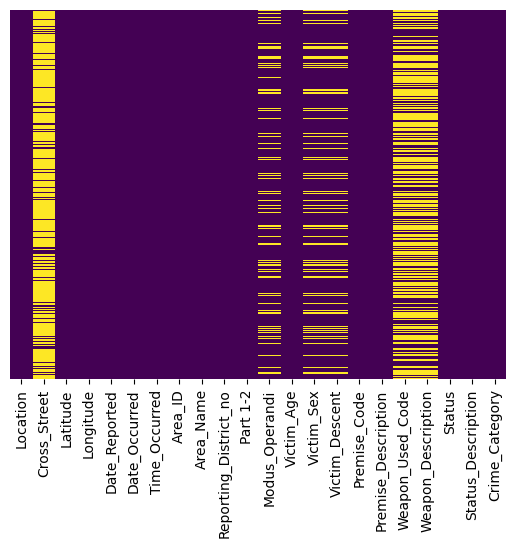

In [14]:
# Visualisation of null values by features
sns.heatmap(train_data.isnull(), yticklabels=False, cbar=False, cmap="viridis");

### **Insights**

#### 1. `Cross_Street`, `Weapon_Description` have a large number of null values(more than 50%) which renders them useless for model training.
#### 2. `Modus_Operandi`, `Victim_Sex`, `Victim_Descent` can be imputed and used for model training.
#### 3. `Weapon_Used_Code` can be still viable for model learning and the large number of null values can be attributed to the absence of a weapon used in the crime.

<a id="t5"></a>
- ### *Target Variable Distribution*

In [15]:
train_data['Crime_Category'].nunique()

6

In [16]:
train_data['Crime_Category'].unique()

array(['Property Crimes', 'Violent Crimes', 'Other Crimes',
       'Crimes against Public Order', 'Fraud and White-Collar Crimes',
       'Crimes against Persons'], dtype=object)

In [17]:
train_data['Crime_Category'].value_counts()/len(train_data)*100

Crime_Category
Property Crimes                  58.330
Violent Crimes                   23.835
Crimes against Public Order       9.040
Fraud and White-Collar Crimes     6.775
Crimes against Persons            1.125
Other Crimes                      0.895
Name: count, dtype: float64

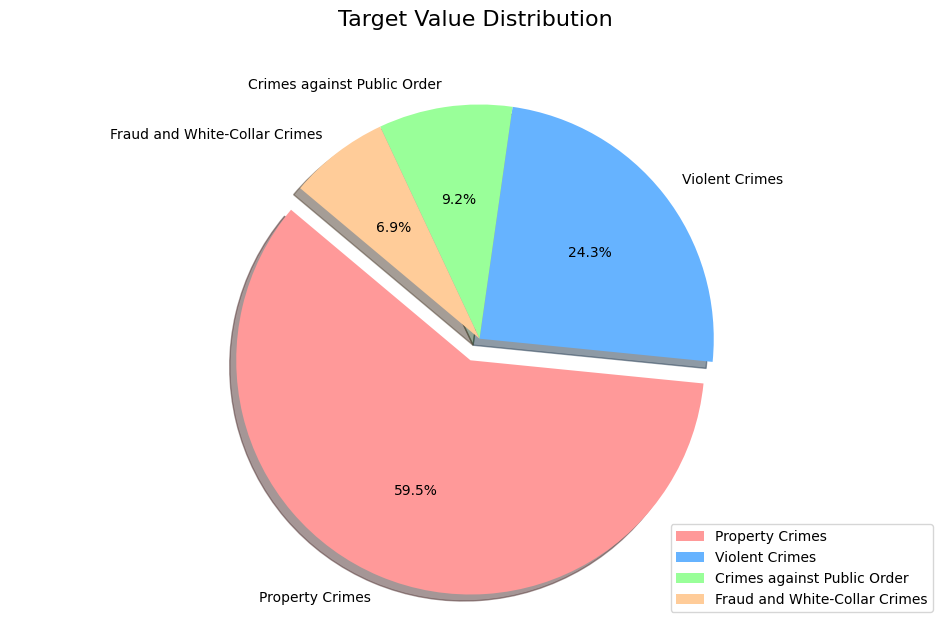

In [18]:
# Pie chart for the top 4 crime categories
pie_labels = train_data['Crime_Category'].value_counts().index[0:4]
pie_values = train_data['Crime_Category'].value_counts().values[0:4]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
explode = (0.1, 0, 0, 0)
plt.figure(figsize=(12,7))
plt.title("Target Value Distribution\n\n", fontsize=16)
plt.pie(pie_values, labels=pie_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, shadow=True)
plt.axis('equal')
plt.legend(pie_labels, loc="lower right");

### **Insights**

#### 1. More than `50 % of the cases` correspond to `Property Crimes`, followed by `Violent Crimes` accounting for `24 % of the cases`.
#### 2. The rest of the `16 %` correspond to `Crimes Against Public Order` and `Fraud and White-Collar Crimes`.
#### 3. A very small percentage also corresponds to `Crimes Against Persons` and `Other Crimes`.

- ### *Correlation of Numerical Features*

In [19]:
le = LabelEncoder()
train_data['target_label_encoded'] = le.fit_transform(train_data['Crime_Category']) 

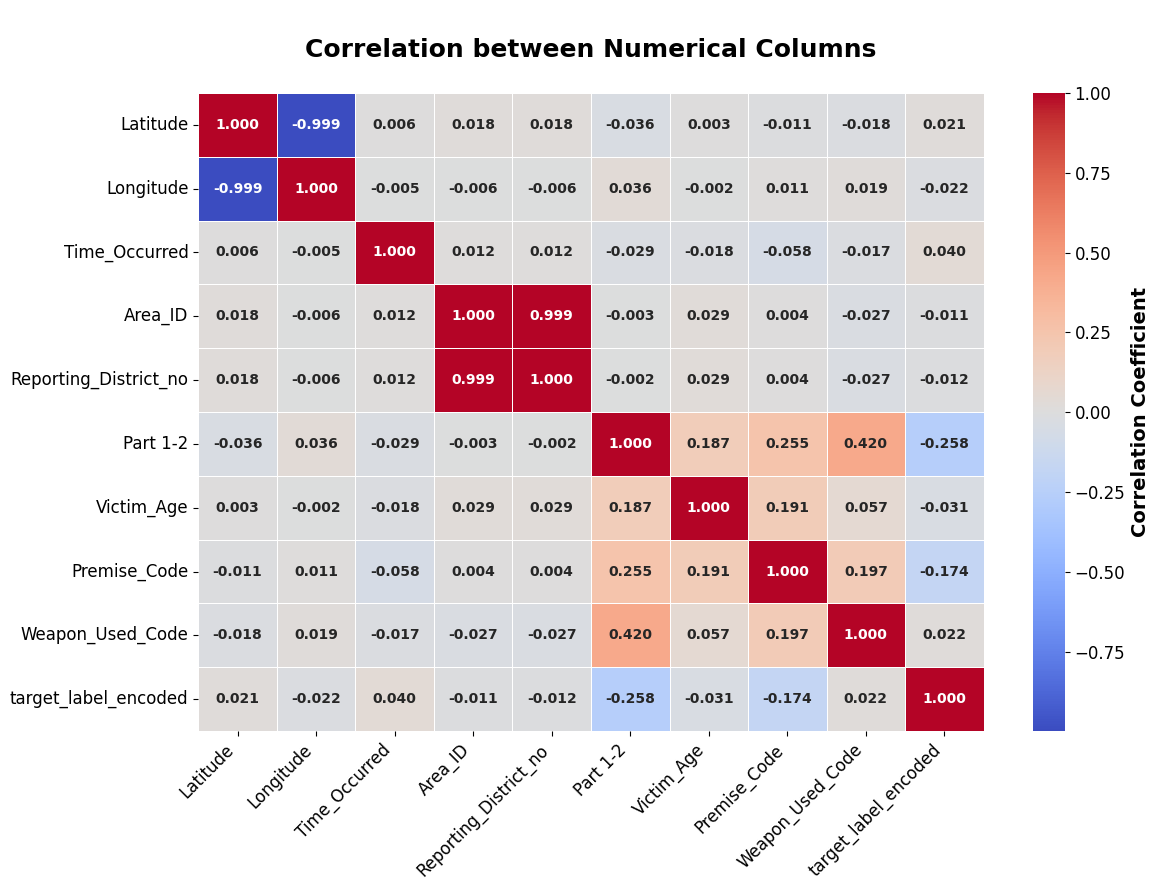

In [20]:
plt.figure(figsize=(12, 9))
plt.title("\nCorrelation between Numerical Columns\n", fontsize=18, fontweight='bold')
heatmap = sns.heatmap(train_data.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5, linecolor='white', 
                      annot_kws={"size": 10, "fontweight": 'bold'})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=12)
colorbar.set_label('Correlation Coefficient', size=14, weight='bold')
plt.tight_layout()

<a id="t6"></a>
## **Univariate Analysis**

- ### *Latitude and Longitude*

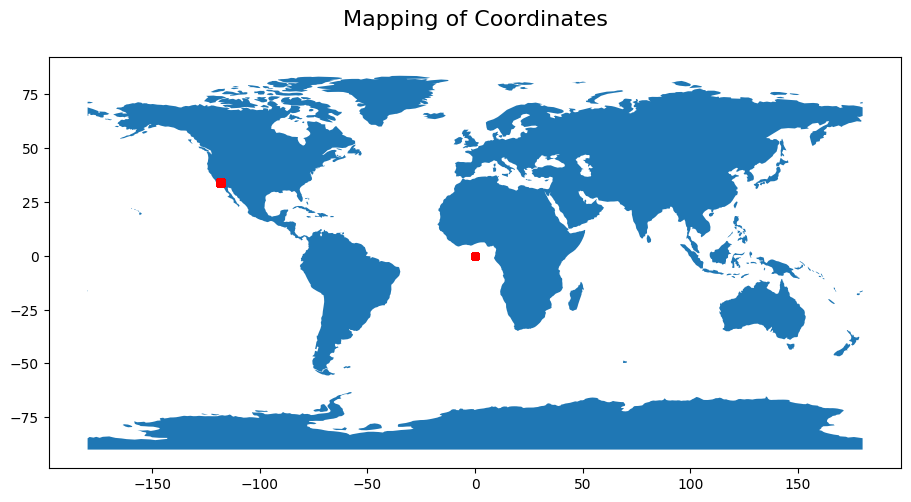

In [21]:
# Plotting Latitudes and Longitudes on world map to identify distribution of cases
geometry = [Point(xy) for xy in zip(train_data['Longitude'], train_data['Latitude'])]
gdf = GeoDataFrame(train_data[['Longitude','Latitude']], geometry=geometry)

world = gpd.read_file(geodatasets.data.naturalearth.land['url'])
gdf.plot(ax = world.plot(figsize=(11,9)), marker='o', color='red', markersize=30);
plt.title("Mapping of Coordinates\n", fontsize=16);

### **Insights**

1. #### Most of the cases in the training dataset belong to North America (in USA specifically) with a few exceptions which need to be worked on in the preprocessing part.

- ### *Premise Description*

In [22]:
# Filling NaN values before generating the string
train_data['Premise_Description'] = train_data["Premise_Description"].fillna(train_data["Premise_Description"].mode()[0])

In [23]:
# Preparing the string for generating the wordcloud
words = []
for i in range(len(train_data)):
    words.append(str(train_data['Premise_Description'].iloc[i]).split("(")[0])

premise_string = ""

for i in range(len(words)):
    word_arr = words[i].split()
    for j in range(len(word_arr)):
        word_arr[j] = word_arr[j].lower()
    premise_string += " ".join(word_arr)+ " "

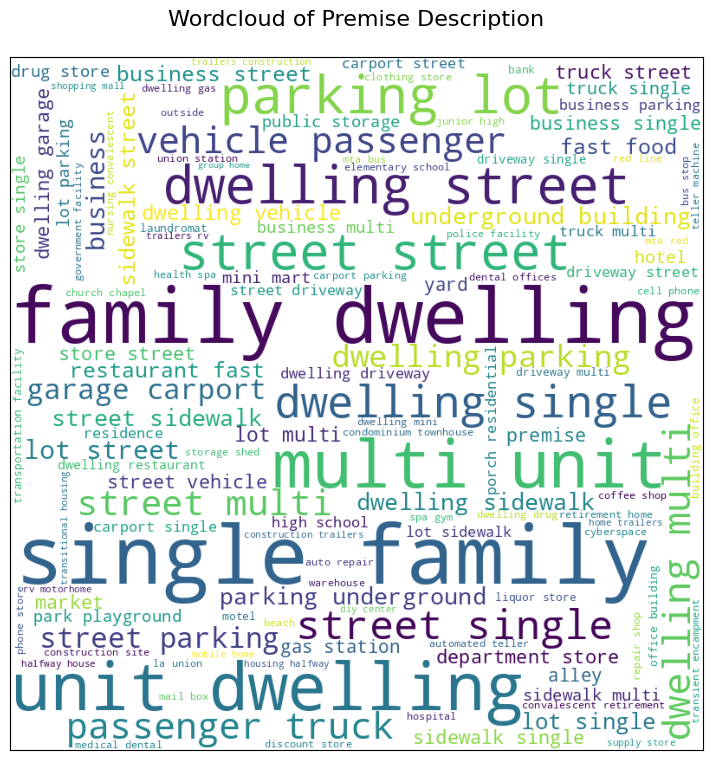

In [24]:
wordcloud = WordCloud(height=800, width=800, stopwords=STOPWORDS, min_font_size=10, background_color='white').generate(premise_string)
plt.figure(figsize=(12,9))
plt.xticks([])
plt.yticks([])
plt.title("Wordcloud of Premise Description\n", fontsize=16)
plt.imshow(wordcloud);

### **Insights**

1. #### `STREET` account for a quarter of the total cases in the training dataset.
2. #### Followed by `SINGLE FAMILY DWELLING` and `MULTI-UNIT DWELLING` premise descriptions account for a quarter of the total cases in the training dataset.
3. #### Rest of the cases belong to the 213 categories remaining.

- ### *Status Description*

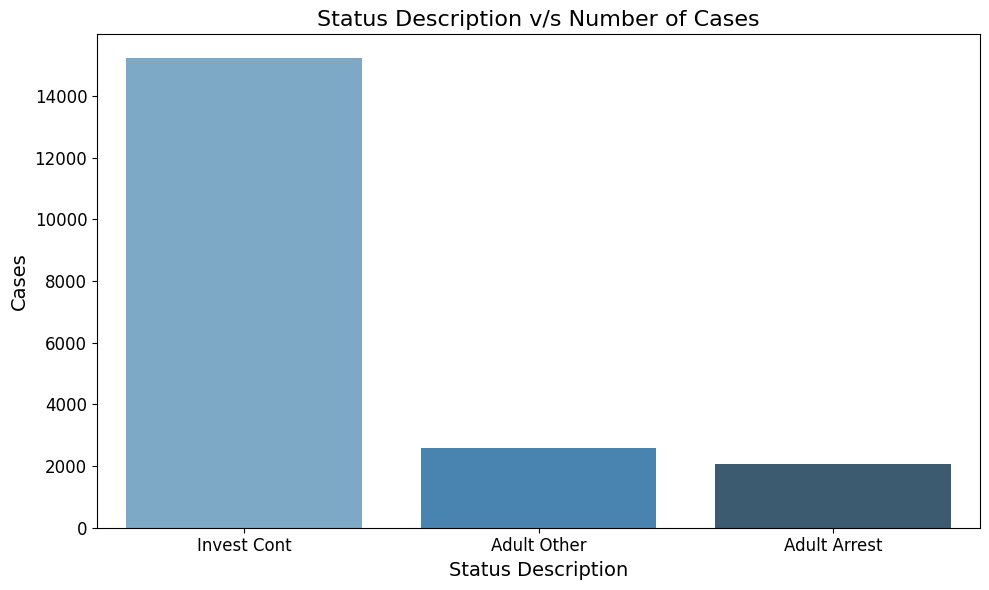

In [25]:
bar_labels = train_data['Status_Description'].value_counts().index[0:3]
bar_values = train_data['Status_Description'].value_counts().values[0:3]
plt.figure(figsize=(10, 6))
sns.barplot(x=bar_labels, y=bar_values, palette='Blues_d')
plt.title('Status Description v/s Number of Cases', fontsize=16)
plt.xlabel('Status Description', fontsize=14) 
plt.ylabel('Cases', fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.tight_layout()

### **Insights**

1. #### More than 75% of the cases fall under the category of `Invest Cont` in the training dataset.
2. #### Rest of the cases in the training dataset fall under the categories `Adult Other` and `Adult Arrest`.

<a id="t7"></a>
## **Multivariate Analysis**

- ### *Victim Age and Category of Crime*

In [26]:
def age_cat(x):
    if x <= 0:
        return 'Others'
    elif 0 < x <= 12.0:
        return 'Children'
    elif x >= 13.0 and x <=17.0:
        return 'Teenagers'
    elif x >= 18.0 and x <=30.0:
        return 'Young Adults'
    elif x <= 60.0 and x>=31.0:
        return "Adults"
    else:
        return "Senior Citizens"

train_data['age_cat'] = train_data['Victim_Age'].apply(age_cat)
test_data['age_cat'] = test_data['Victim_Age'].apply(age_cat)

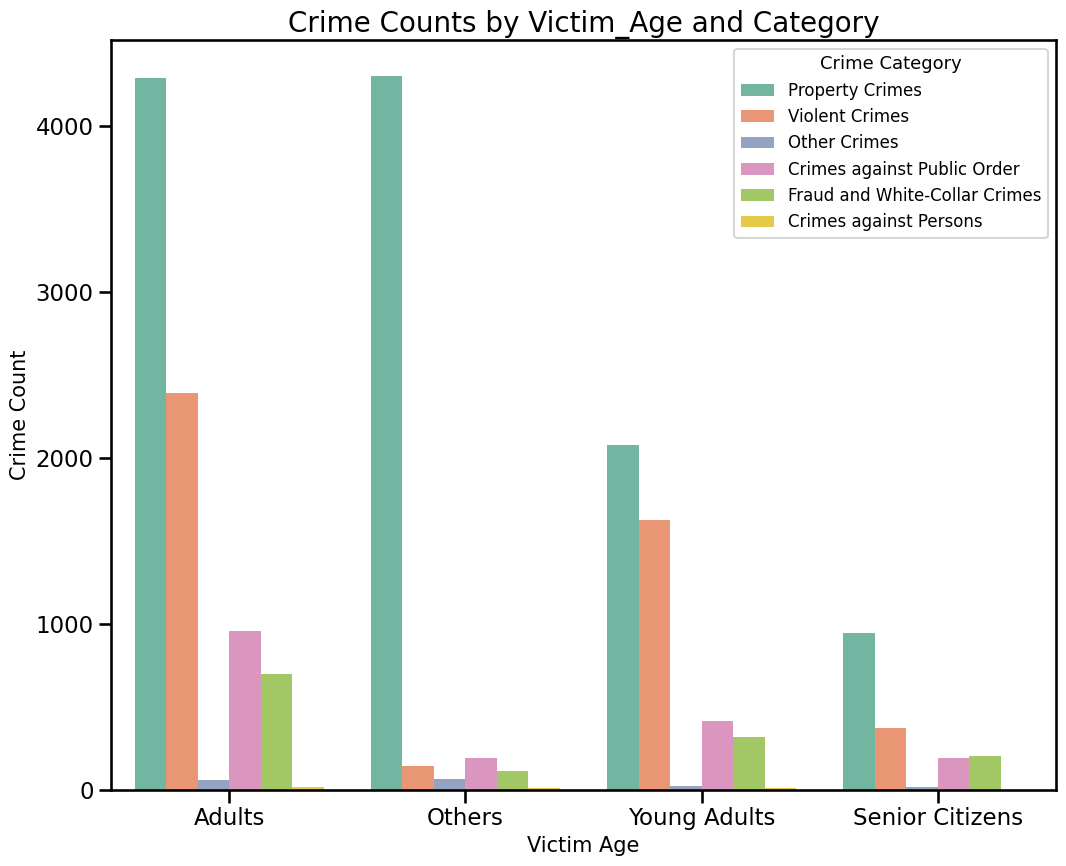

In [27]:
sns.set_context("talk")
plt.figure(figsize=(11, 9))
sns.countplot(data=train_data, x='age_cat', hue='Crime_Category', palette='Set2', order=train_data['age_cat'].value_counts().index[0:4])
plt.title('Crime Counts by Victim_Age and Category', fontsize=20)
plt.xlabel('Victim Age', fontsize=15)
plt.ylabel('Crime Count', fontsize=15)
plt.legend(title='Crime Category', title_fontsize='13', loc='upper right', fontsize='12')
plt.tight_layout()

### **Insights**

1. #### `Adults(31 years to 60 years old)` are the major victims of `Violent Crimes` followed by `Young Adults(18 years to 30 years old)`.
2. #### The same order is also followed for `Property Crimes`, `Crimes against Public Order` and `Fraud and White-Collar Crimes` as well.

- ### *Victim Sex and Category of Crime*

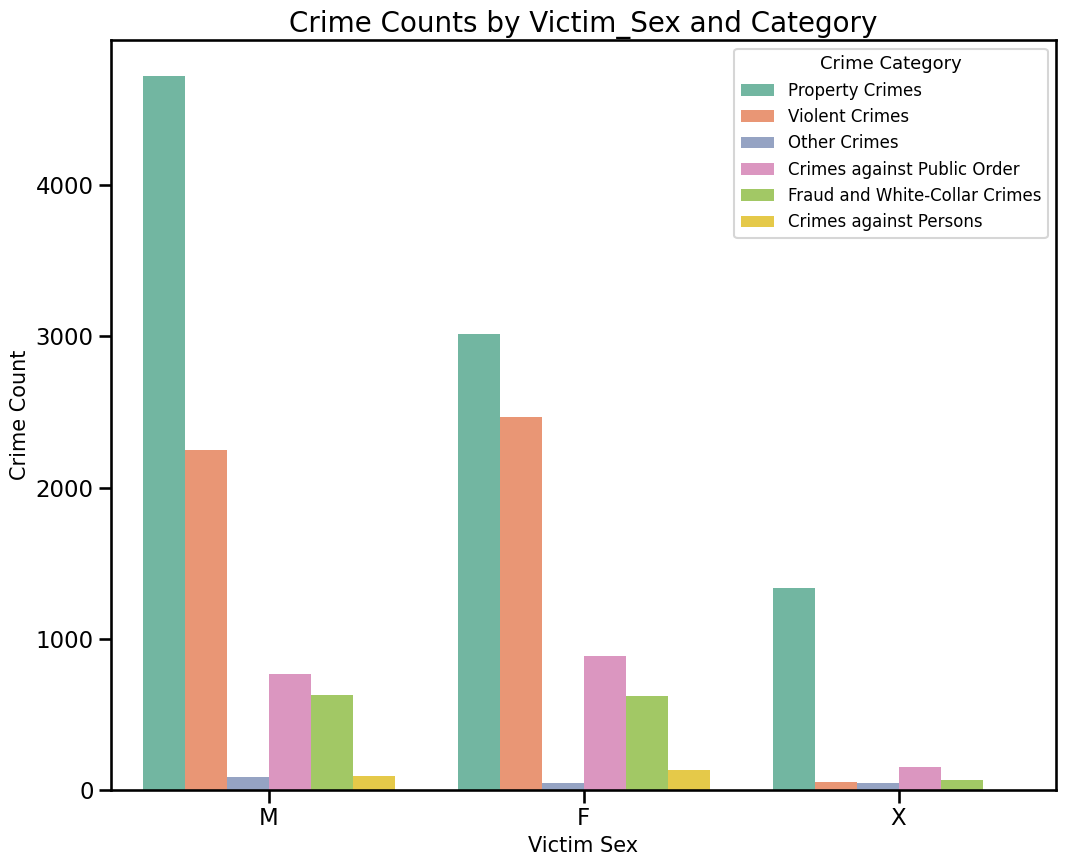

In [28]:
sns.set_context("talk")
plt.figure(figsize=(11, 9))
sns.countplot(data=train_data, x='Victim_Sex', hue='Crime_Category', palette='Set2', order=train_data['Victim_Sex'].value_counts().index[0:3])
plt.title('Crime Counts by Victim_Sex and Category', fontsize=20)
plt.xlabel('Victim Sex', fontsize=15)
plt.ylabel('Crime Count', fontsize=15)
plt.legend(title='Crime Category', title_fontsize='13', loc='upper right', fontsize='12')
plt.tight_layout()

### **Insights**

1. #### `F` are the major victims of `Violent Crimes` and `Crimes against Public Order` whereas `M` are the major victims of `Property Crimes` and `Fraud and White-Collar Crimes`.

- ### *Area Name and Category of Crime*

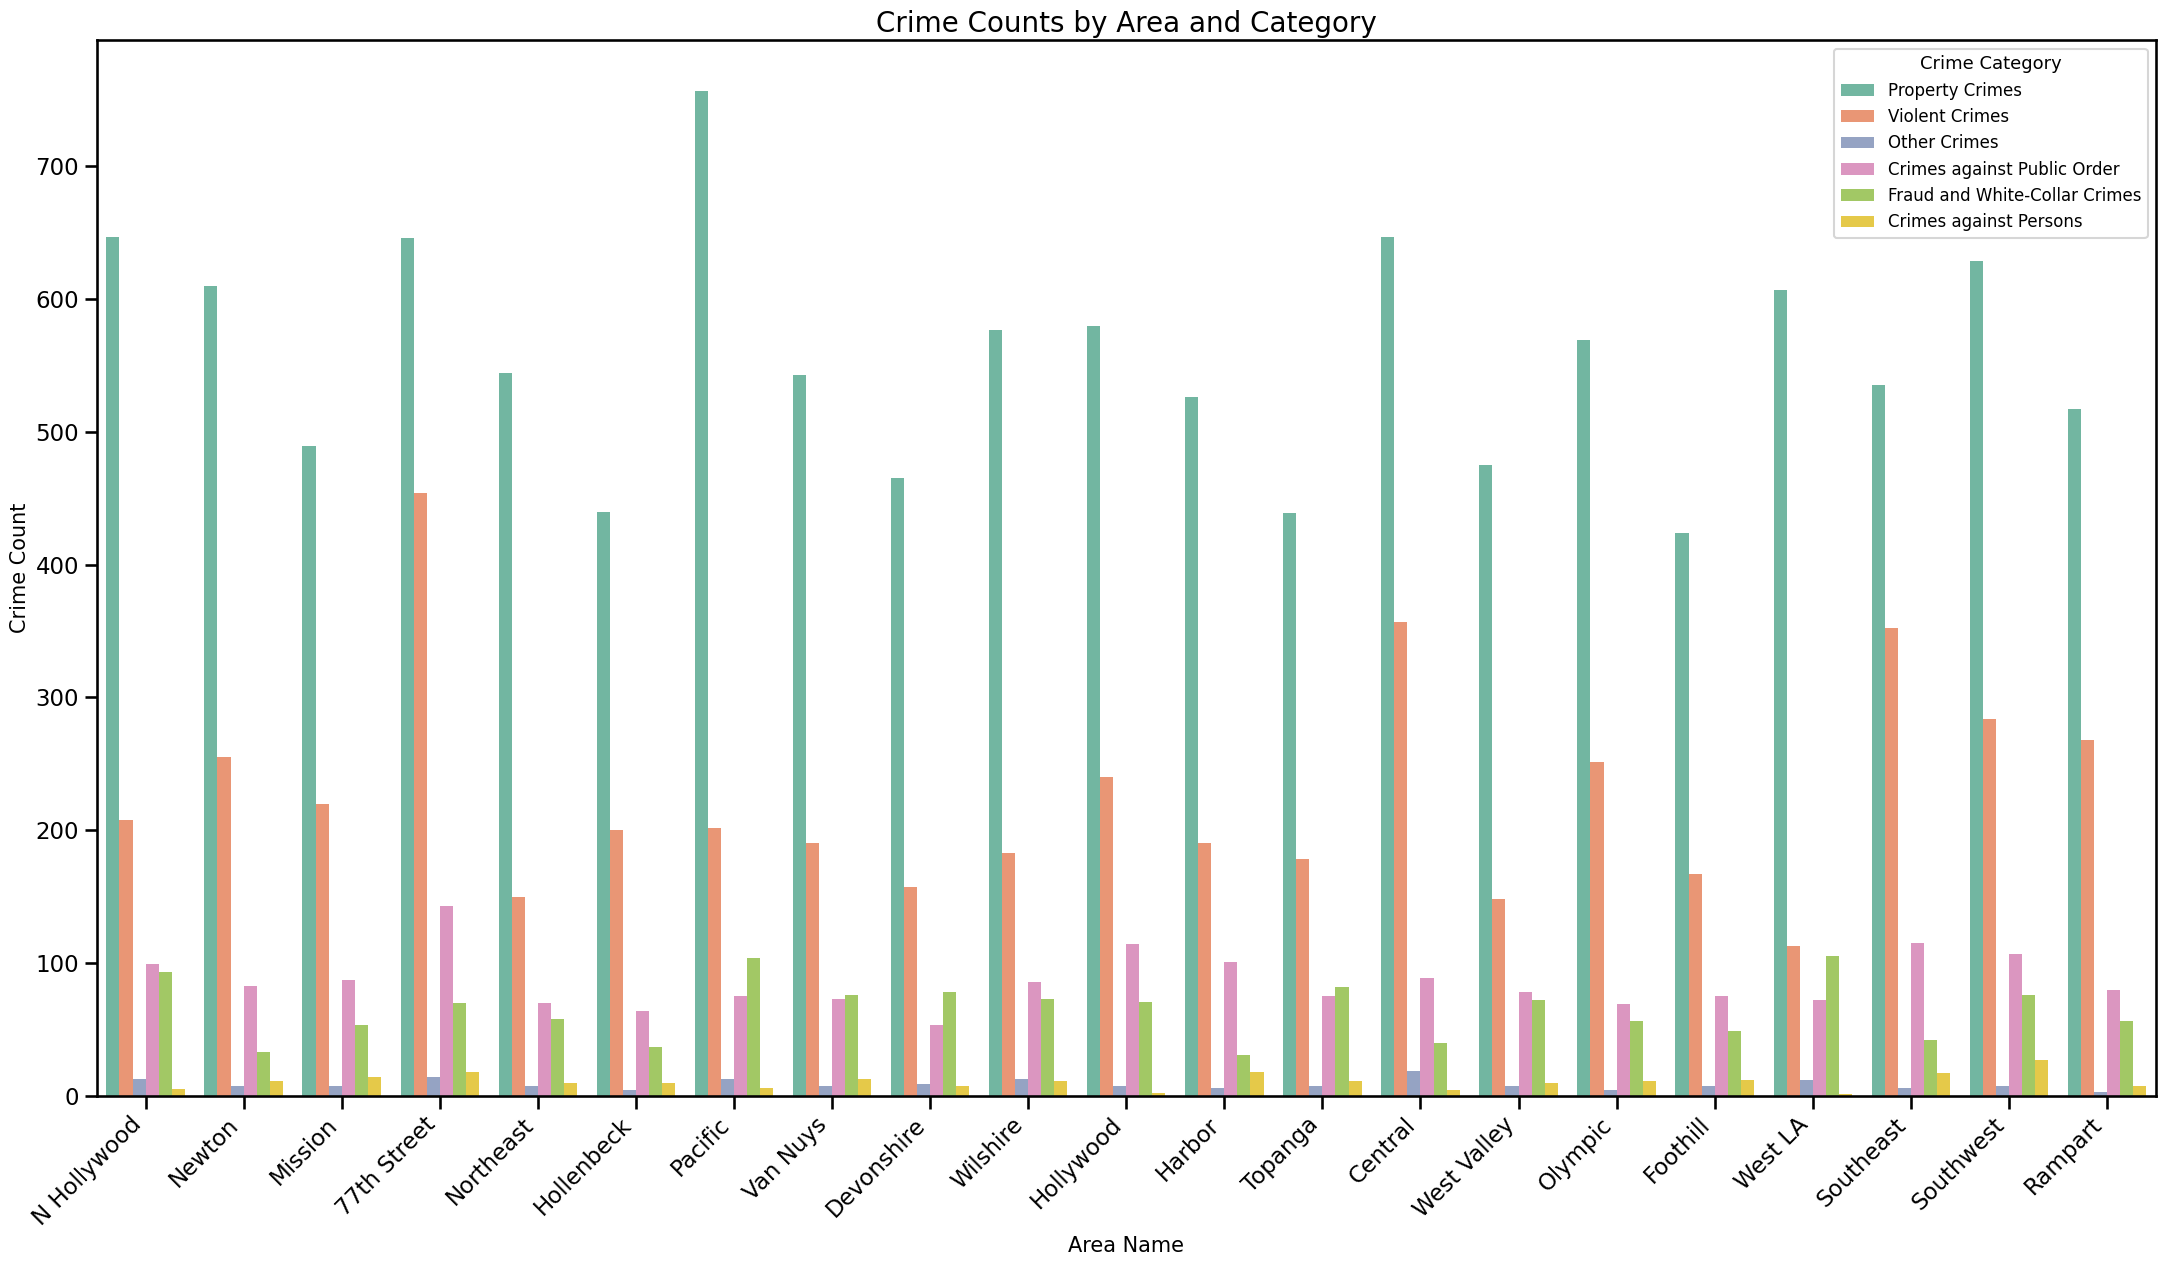

In [29]:
sns.set_context("talk")
plt.figure(figsize=(22, 13))
sns.countplot(data=train_data, x='Area_Name', hue='Crime_Category', palette='Set2')
plt.title('Crime Counts by Area and Category', fontsize=20)
plt.xlabel('Area Name', fontsize=15)
plt.ylabel('Crime Count', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Crime Category', title_fontsize='13', loc='upper right', fontsize='12')
plt.tight_layout()

### **Insights**

1. #### `Pacific` has the largest number of `Property Crimes` in the training dataset.
2. #### `77th Street` has the largest number of `Violent Crimes` cases as well as `Crimes against Public Order` cases in the training dataset.

<a id="t12"></a>
## *Dropping Redundant Columns before Preprocessing*

In [30]:
train_data.drop('Cross_Street', axis=1, inplace=True) # Dropping Cross_Street for having more than 80 % of its values as null
train_data.drop('Weapon_Description', axis=1, inplace=True) # Dropping Weapon_Description for having more than 60 % of its values as null
train_data.drop('Location', axis=1, inplace=True) # Dropping Location as it is redundant
train_data.drop('Date_Reported', axis=1, inplace=True) # Dropping Date_Reported as it should have no weight on classification of crime
train_data.drop('Date_Occurred', axis=1, inplace=True) # Dropping Date_Occured as it should have no weight on classification of crime
train_data.drop('Area_Name', axis=1, inplace=True) # Dropping Area_Name as it is redundant
train_data.drop('Premise_Description', axis=1, inplace=True) # Dropping Premise_Description as it is redundant
train_data.drop('Status_Description', axis=1, inplace=True) # Dropping Status_Description as it is redundant
train_data.drop('target_label_encoded', axis=1, inplace=True) # Dropping Target Label Encoded as it is redundant
train_data.drop('age_cat', axis=1, inplace=True) # Dropping Age Category as it is redundant

In [31]:
test_data.drop('Cross_Street', axis=1, inplace=True) # Dropping Cross_Street for having more than 80 % of its values as null
test_data.drop('Weapon_Description', axis=1, inplace=True) # Dropping Weapon_Description for having more than 60 % of its values as null
test_data.drop('Location', axis=1, inplace=True) # Dropping Location as it is redundant
test_data.drop('Date_Reported', axis=1, inplace=True) # Dropping Date_Reported as it should have no weight on classification of crime
test_data.drop('Date_Occurred', axis=1, inplace=True) # Dropping Date_Occured as it should have no weight on classification of crime
test_data.drop('Area_Name', axis=1, inplace=True) # Dropping Area_Name as it is redundant
test_data.drop('Premise_Description', axis=1, inplace=True) # Dropping Premise_Description as it is redundant
test_data.drop('Status_Description', axis=1, inplace=True) # Dropping Status_Description as it is redundant
test_data.drop('age_cat', axis=1, inplace=True) # Dropping Age Category as it is redundant

In [32]:
# Feature Engineering Time_Occured column of the data set
def assign_cat(x):
    if x >= 0 and x < 600:
        return "Early Morning"
    elif x >= 600 and x < 1200:
        return "Morning"
    elif x >= 1200 and x < 1800:
        return "Afternoon"
    elif x >= 1800 and x < 2400:
        return "Night"

train_data['Time_Occurred_Cat'] = train_data['Time_Occurred'].apply(assign_cat)
test_data['Time_Occurred_Cat'] = test_data['Time_Occurred'].apply(assign_cat)
train_data.drop('Time_Occurred', axis=1, inplace=True) # Dropping Time_Occured as it is redundant
test_data.drop('Time_Occurred', axis=1, inplace=True) # Dropping Time_Occured as it is redundant

<a id="t8"></a>
# **Preprocessing**

In [33]:
imp = SimpleImputer(strategy="most_frequent")

In [34]:
# Imputing Train Data
train_data['Modus_Operandi'] = imp.fit_transform(train_data[['Modus_Operandi']]).flatten()
train_data['Victim_Sex'] = imp.fit_transform(train_data[['Victim_Sex']]).flatten()
train_data['Victim_Descent'] = imp.fit_transform(train_data[['Victim_Descent']]).flatten()

In [35]:
# Imputing Test Data
test_data['Modus_Operandi'] = imp.fit_transform(test_data[['Modus_Operandi']]).flatten()
test_data['Victim_Sex'] = imp.fit_transform(test_data[['Victim_Sex']]).flatten()
test_data['Victim_Descent'] = imp.fit_transform(test_data[['Victim_Descent']]).flatten()

In [36]:
# Imputing Longitudes and Latitudes

def replace_zeros_by_nan(x):
    if x == 0.0:
        return np.nan
    else:
        return x

train_data['Latitude'] = train_data['Latitude'].apply(replace_zeros_by_nan)
train_data['Longitude'] = train_data['Longitude'].apply(replace_zeros_by_nan)
test_data['Latitude'] = test_data['Latitude'].apply(replace_zeros_by_nan)
test_data['Longitude'] = test_data['Longitude'].apply(replace_zeros_by_nan)

train_data['Latitude'] = train_data['Latitude'].fillna(train_data['Latitude'].mean())
train_data['Longitude'] = train_data['Longitude'].fillna(train_data['Longitude'].mean())
test_data['Latitude'] = test_data['Latitude'].fillna(test_data['Latitude'].mean())
test_data['Longitude'] = test_data['Longitude'].fillna(test_data['Longitude'].mean())

In [37]:
def replace_lessthanzero_by_na(x):
    if x < 0.0:
        return np.nan
    else:
        return x

# Imputing Victim_Age
train_data['Victim_Age'] = train_data['Victim_Age'].apply(replace_lessthanzero_by_na)
test_data['Victim_Age'] = test_data['Victim_Age'].apply(replace_lessthanzero_by_na)

train_data['Victim_Age'] = train_data['Victim_Age'].fillna(value=0.0)
test_data['Victim_Age'] = test_data['Victim_Age'].fillna(value=0.0)

In [38]:
# Imputing Weapon_Used_Code
train_data['Weapon_Used_Code'] = train_data['Weapon_Used_Code'].fillna(value=-1)
test_data['Weapon_Used_Code'] = test_data['Weapon_Used_Code'].fillna(value=-1)

In [39]:
train_data.columns

Index(['Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no', 'Part 1-2',
       'Modus_Operandi', 'Victim_Age', 'Victim_Sex', 'Victim_Descent',
       'Premise_Code', 'Weapon_Used_Code', 'Status', 'Crime_Category',
       'Time_Occurred_Cat'],
      dtype='object')

In [40]:
numerical_cols = ['Latitude', 'Longitude', 'Area_ID','Victim_Age', 'Reporting_District_no', 'Part 1-2','Premise_Code']
categorical_cols = ['Victim_Sex', 'Victim_Descent','Status','Time_Occurred_Cat','Weapon_Used_Code']
textual_cols = ['Modus_Operandi']

In [41]:
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

textual_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer())
])

In [42]:
preprocessor = ColumnTransformer([
    ('num_pipe', numerical_pipeline, numerical_cols),
    ('cat_pipe', categorical_pipeline, categorical_cols),
    ('text_pipe', textual_pipeline, 'Modus_Operandi')
])

In [43]:
X = train_data.drop('Crime_Category',axis=1)
y = train_data['Crime_Category']

In [44]:
X.head()

,Latitude,Longitude,Area_ID,Reporting_District_no,Part 1-2,Modus_Operandi,Victim_Age,Victim_Sex,Victim_Descent,Premise_Code,Weapon_Used_Code,Status,Time_Occurred_Cat
0,34.1522,-118.3910,15.0,1563.0,1.0,0385,75.0,M,W,101.0,-1.0,IC,Night
1,34.0028,-118.2391,13.0,1367.0,1.0,0906 0352 0371 0446 1822 0344 0416 0417,41.0,M,H,216.0,400.0,IC,Afternoon
2,34.0111,-118.2653,13.0,1343.0,2.0,0329 1202,67.0,M,B,501.0,-1.0,IC,Morning
3,34.2953,-118.4590,19.0,1924.0,1.0,0329 1300,61.0,M,H,101.0,-1.0,IC,Night
4,33.9787,-118.2918,12.0,1245.0,1.0,0416 0945 1822 0400 0417 0344,0.0,X,X,401.0,400.0,IC,Morning


In [45]:
X_train_process = preprocessor.fit_transform(X)
X_test_process = preprocessor.transform(test_data)

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_train_process, y, test_size=0.3, stratify=y, random_state=42)

In [47]:
smt = SMOTE(random_state=0)
X_train_resam, y_train_resam = smt.fit_resample(X_train, y_train)

<a id="t9"></a>
# **Model Selection and Evaluation**

<a id="t15"></a>
## **Random Forest Classifier**

In [48]:
# Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train_resam, y_train_resam)
y_pred = rf.predict(X_val)

### Accuracy Score

In [49]:
score_rf = accuracy_score(y_val, y_pred)
score_rf

0.9496666666666667

### Classification Report

In [50]:
class_report_rf = classification_report(y_val,y_pred)
print(class_report_rf)

                               precision    recall  f1-score   support

       Crimes against Persons       0.83      0.63      0.72        68
  Crimes against Public Order       0.83      0.87      0.85       542
Fraud and White-Collar Crimes       0.93      0.92      0.93       406
                 Other Crimes       0.62      0.15      0.24        54
              Property Crimes       0.99      0.98      0.98      3500
               Violent Crimes       0.91      0.97      0.94      1430

                     accuracy                           0.95      6000
                    macro avg       0.85      0.75      0.78      6000
                 weighted avg       0.95      0.95      0.95      6000



### Confusion Matrix

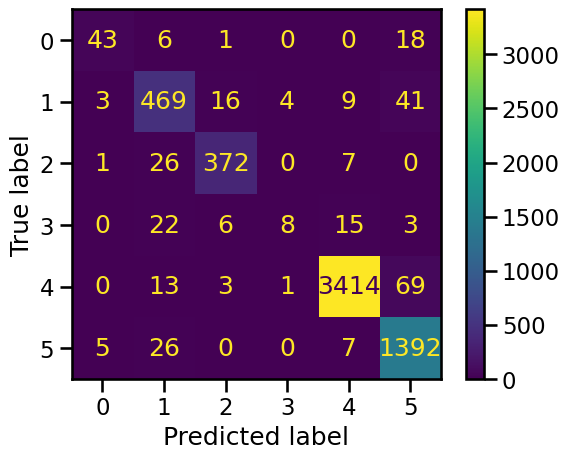

In [51]:
conf_matrix_rf = confusion_matrix(y_val, y_pred)
display_mat = ConfusionMatrixDisplay(conf_matrix_rf)
display_mat.plot();

<a id="t16"></a>
## **LGBM Classifier**

In [52]:
# #LightGBM Classifier
lgbm = LGBMClassifier(learning_rate= 0.1,max_depth= 11,min_data_in_leaf= 25,num_leaves= 20,verbose=-1) # Best One Yet
lgbm.fit(X_train_resam, y_train_resam)
y_pred = lgbm.predict(X_val)

### Accuracy Score

In [53]:
score_lgbm = accuracy_score(y_val, y_pred)
score_lgbm

0.9573333333333334

### Classification Report

In [54]:
class_report_lgbm = classification_report(y_val,y_pred)
print(class_report_lgbm)

                               precision    recall  f1-score   support

       Crimes against Persons       0.70      0.65      0.67        68
  Crimes against Public Order       0.85      0.88      0.86       542
Fraud and White-Collar Crimes       0.93      0.92      0.93       406
                 Other Crimes       0.59      0.48      0.53        54
              Property Crimes       0.99      0.99      0.99      3500
               Violent Crimes       0.94      0.96      0.95      1430

                     accuracy                           0.96      6000
                    macro avg       0.83      0.81      0.82      6000
                 weighted avg       0.96      0.96      0.96      6000



###  Confusion Matrix

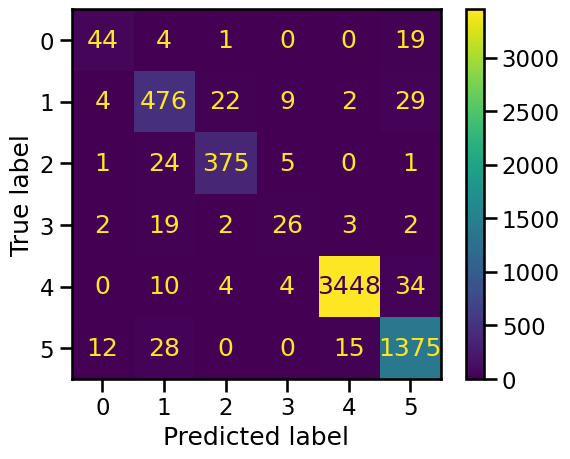

In [55]:
conf_matrix_lgbm = confusion_matrix(y_val, y_pred)
display_mat = ConfusionMatrixDisplay(conf_matrix_lgbm)
display_mat.plot();

<a id="t17"></a>
## **XGBoost Classifier**

In [56]:
# XGBoost Classifier
xg = XGBClassifier(random_state=0,learning_rate=0.1, max_delta_step=2, max_depth=11)
xg.fit(X_train_resam, le.fit_transform(y_train_resam))
y_pred = le.inverse_transform(xg.predict(X_val))

### Accuracy Score

In [57]:
score_xg = accuracy_score(y_val, y_pred)
score_xg

0.9576666666666667

### Classification Report

In [58]:
class_report_xg = classification_report(y_val,y_pred)
print(class_report_xg)

                               precision    recall  f1-score   support

       Crimes against Persons       0.74      0.68      0.71        68
  Crimes against Public Order       0.86      0.87      0.86       542
Fraud and White-Collar Crimes       0.91      0.94      0.92       406
                 Other Crimes       0.67      0.41      0.51        54
              Property Crimes       0.99      0.99      0.99      3500
               Violent Crimes       0.94      0.96      0.95      1430

                     accuracy                           0.96      6000
                    macro avg       0.85      0.81      0.82      6000
                 weighted avg       0.96      0.96      0.96      6000



### Confusion Matrix

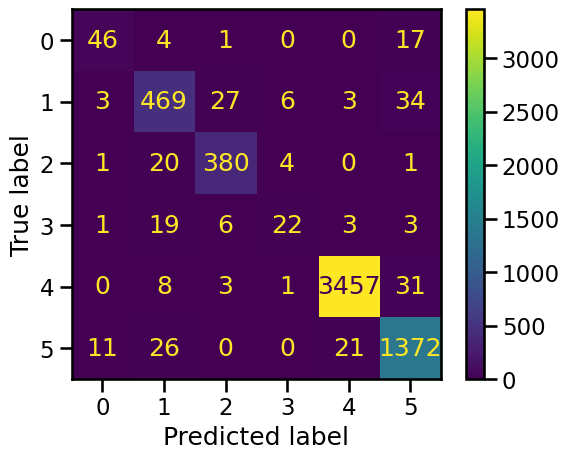

In [59]:
conf_matrix_xg = confusion_matrix(y_val, y_pred)
display_mat = ConfusionMatrixDisplay(conf_matrix_xg)
display_mat.plot();

<a id="t18"></a>
## **Model Evaluation**

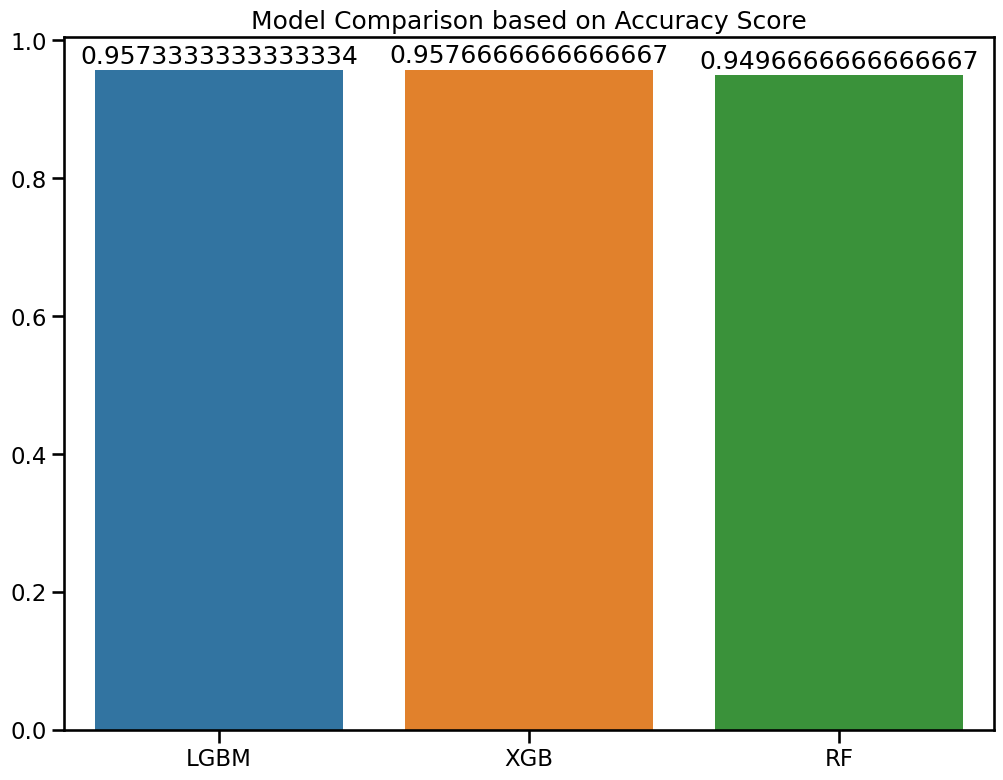

In [60]:
model_n = np.array(['LGBM', 'XGB', 'RF'])
model_score = np.array([score_lgbm, score_xg, score_rf])

plt.figure(figsize=(12,9))
ax = sns.barplot(x=model_n, y=model_score)
plt.title('Model Comparison based on Accuracy Score')
for i, v in enumerate(model_score):
    ax.text(i, float(v)+0.01, str(v), ha="center")

In [61]:
# # KNeighborsClassifier along with Hyperparameter Tuning
# params = {
#     'n_neighbors':[5,7,11,19],
#     'p':[1,2],
#     'weights':['uniform','distance']
# }
# knn = KNeighborsClassifier()

# Support Vector Classifier
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred = svc.predict(X_val)

# Decision Tree Classifier
# dt = DecisionTreeClassifier()
# dt.fit(X_train, y_train)
# y_pred = dt.predict(X_val)

# # Multi Layer Perceptron Classifier
# mlp = MLPClassifier(max_iter=1000)
# mlp.fit(X_train, y_train)
# y_pred = mlp.predict(X_val)

<a id="t13"></a>
# **Hyperparameter Tuning**

## **Tuning LGBM Model**

In [62]:
# Param Grid
# param_xg = {
#     'learning_rate':[0.1,0.2,0.3],
# #     'num_leaves':[15,20,25],
#     'max_depth':[10,11,12],
#     'max_delta_step':[0,2, 4, 6]
#  }

In [63]:
# gs = GridSearchCV(estimator=xg, param_grid=param_xg, cv=5)

In [64]:
# gs.fit(X_train_process, le.fit_transform(y))

In [65]:
# y_pred = gs.predict(X_test_process)

In [66]:
# gs.best_params_

In [67]:
# gs.best_score_

In [68]:
X_train_process_resamp, y_resamp = smt.fit_resample(X_train_process, y)
# Final Classifier Training
xg.fit(X_train_process_resamp, le.fit_transform(y_resamp))
y_pred = le.inverse_transform(xg.predict(X_test_process))

In [69]:
submission = pd.DataFrame({"ID":np.arange(1,5001),
                           "Crime_Category":y_pred})
submission.to_csv("submission.csv", index=False)